In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:


# import system libs
import os
import time
import shutil
import pathlib
import itertools

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
import missingno as msno
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from plotly.offline import iplot

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print('Modules loaded')


Modules loaded


In [ ]:
tf.__version__

'2.15.0'

In [ ]:

train_data_path = '/content/drive/MyDrive/oral/train'
test_data_path = '/content/drive/MyDrive/oral/test'
valid_data_path = '/content/drive/MyDrive/oral/val'
data_dir = '/content/drive/MyDrive/oral'


In [ ]:


# Creating dataframes for dataset
def generate_data_paths(data_dir):

    filepaths = []
    labels = []

    folds = ['train', 'test', 'val']
    for fold in folds:
        foldpath = os.path.join(data_dir, fold)
        classes = os.listdir(foldpath)
        for cls in classes:
            classpath = os.path.join(foldpath, cls)
            filelist = os.listdir(classpath)
            for file in filelist:
                fpath = os.path.join(classpath, file)
                filepaths.append(fpath)
                labels.append(cls)

    return filepaths, labels

filepaths, labels = generate_data_paths(data_dir)


In [ ]:
def create_df(filepaths, labels):

    Fseries = pd.Series(filepaths, name='filepaths')
    Lseries = pd.Series(labels, name='labels')
    df = pd.concat([Fseries, Lseries], axis=1)
    return df

df = create_df(filepaths, labels)


In [ ]:
df.head()


filepaths labels
0  /content/drive/MyDrive/oral/train/OSCC/aug_353...   OSCC
1  /content/drive/MyDrive/oral/train/OSCC/aug_353...   OSCC
2  /content/drive/MyDrive/oral/train/OSCC/aug_35_...   OSCC
3  /content/drive/MyDrive/oral/train/OSCC/aug_355...   OSCC
4  /content/drive/MyDrive/oral/train/OSCC/aug_361...   OSCC

In [ ]:
# Defining no of images
def num_of_examples(df, name='df'):
    print(f"The {name} dataset has {df.shape[0]} images.")

num_of_examples(df, 'dataset')


The dataset dataset has 5212 images.


In [ ]:

# Defining no of classes
def num_of_classes(df, name='df'):
    print(f"The {name} dataset has {len(df['labels'].unique())} classes")

num_of_classes(df, 'dataset')


The dataset dataset has 2 classes


In [ ]:
# Displaying no of images in each class
def classes_count(df, name='df'):

    print(f"The {name} dataset has: ")
    print("="*70)
    print()
    for name in df['labels'].unique():
        num_class = len(df['labels'][df['labels'] == name])
        print(f"Class '{name}' has {num_class} images")
        print('-'*70)

classes_count(df, 'dataset')


The dataset dataset has: 

Class 'OSCC' has 2718 images
----------------------------------------------------------------------
Class 'Normal' has 2494 images
----------------------------------------------------------------------


In [ ]:
# Visualization
def cat_summary_with_graph(dataframe, col_name):
    fig = make_subplots(rows=1, cols=2,
                        subplot_titles=('Countplot', 'Percentages'),
                        specs=[[{"type": "xy"}, {'type': 'domain'}]])

    fig.add_trace(go.Bar(y=dataframe[col_name].value_counts().values.tolist(),
                         x=[str(i) for i in dataframe[col_name].value_counts().index],
                         text=dataframe[col_name].value_counts().values.tolist(),
                         textfont=dict(size=15),
                         name=col_name,
                         textposition='auto',
                         showlegend=False,
                         marker=dict(color=colors,
                                     line=dict(color='#DBE6EC',
                                               width=1))),
                  row=1, col=1)

    fig.add_trace(go.Pie(labels=dataframe[col_name].value_counts().keys(),
                         values=dataframe[col_name].value_counts().values,
                         textfont=dict(size=20),
                         textposition='auto',
                         showlegend=False,
                         name=col_name,
                         marker=dict(colors=colors)),
                  row=1, col=2)

    fig.update_layout(title={'text': col_name,
                             'y': 0.9,
                             'x': 0.5,
                             'xanchor': 'center',
                             'yanchor': 'top'},
                      template='plotly_white')

    iplot(fig)

colors = ['#494BD3', '#E28AE2', '#F1F481', '#79DB80', '#DF5F5F',
          '#69DADE', '#C2E37D', '#E26580', '#D39F49', '#B96FE3']

cat_summary_with_graph(df, 'labels')


In [ ]:

# Splitting into train & test dataframe
# train dataframe
train_df, dummy_df = train_test_split(df, train_size=0.7, shuffle=True, random_state=123)

# valid and test dataframe
valid_df, test_df = train_test_split(dummy_df, train_size=0.5, shuffle=True, random_state=123)

num_of_classes(train_df, "Training dataset")
num_of_classes(valid_df, "Validation dataset")
num_of_classes(test_df, "Testing dataset")

classes_count(train_df, 'Training dataset')
classes_count(valid_df, 'Validation dataset')
classes_count(test_df, 'Testing dataset')

from keras.preprocessing.image import ImageDataGenerator


The Training dataset dataset has 2 classes
The Validation dataset dataset has 2 classes
The Testing dataset dataset has 2 classes
The Training dataset dataset has: 

Class 'Normal' has 1729 images
----------------------------------------------------------------------
Class 'OSCC' has 1919 images
----------------------------------------------------------------------
The Validation dataset dataset has: 

Class 'OSCC' has 390 images
----------------------------------------------------------------------
Class 'Normal' has 392 images
----------------------------------------------------------------------
The Testing dataset dataset has: 

Class 'Normal' has 373 images
----------------------------------------------------------------------
Class 'OSCC' has 409 images
----------------------------------------------------------------------


In [ ]:


# Image data generator
# resizing images
batch_size = 16
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)


In [ ]:
# Recommended: use custom function for test data batch size, else we can use normal batch size.
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length % n == 0 and ts_length / n <= 80]))
test_steps = ts_length // test_batch_size

# This function which will be used in image data generator for data augmentation, it just takes the image and returns it again.
def scalar(img):
    return img

tr_gen = ImageDataGenerator(preprocessing_function=scalar,
                            horizontal_flip=True)

ts_gen = ImageDataGenerator(preprocessing_function=scalar)

train_gen = tr_gen.flow_from_dataframe(train_df,
                                       x_col='filepaths',
                                       y_col='labels',
                                       target_size=img_size,
                                       class_mode='categorical',
                                       color_mode='rgb',
                                       shuffle=True,
                                       batch_size=batch_size)

valid_gen = ts_gen.flow_from_dataframe(valid_df,
                                       x_col='filepaths',
                                       y_col='labels',
                                       target_size=img_size,
                                       class_mode='categorical',
                                       color_mode='rgb',
                                       shuffle=True,
                                       batch_size=batch_size)


Found 3648 validated image filenames belonging to 2 classes.
Found 782 validated image filenames belonging to 2 classes.


In [ ]:
# Note: we will use custom test_batch_size, and make shuffle= false
test_gen = ts_gen.flow_from_dataframe(test_df,
                                      x_col='filepaths',
                                      y_col='labels',
                                      target_size=img_size,
                                      class_mode='categorical',
                                      color_mode='rgb',
                                      shuffle=False,
                                      batch_size=test_batch_size)


Found 782 validated image filenames belonging to 2 classes.


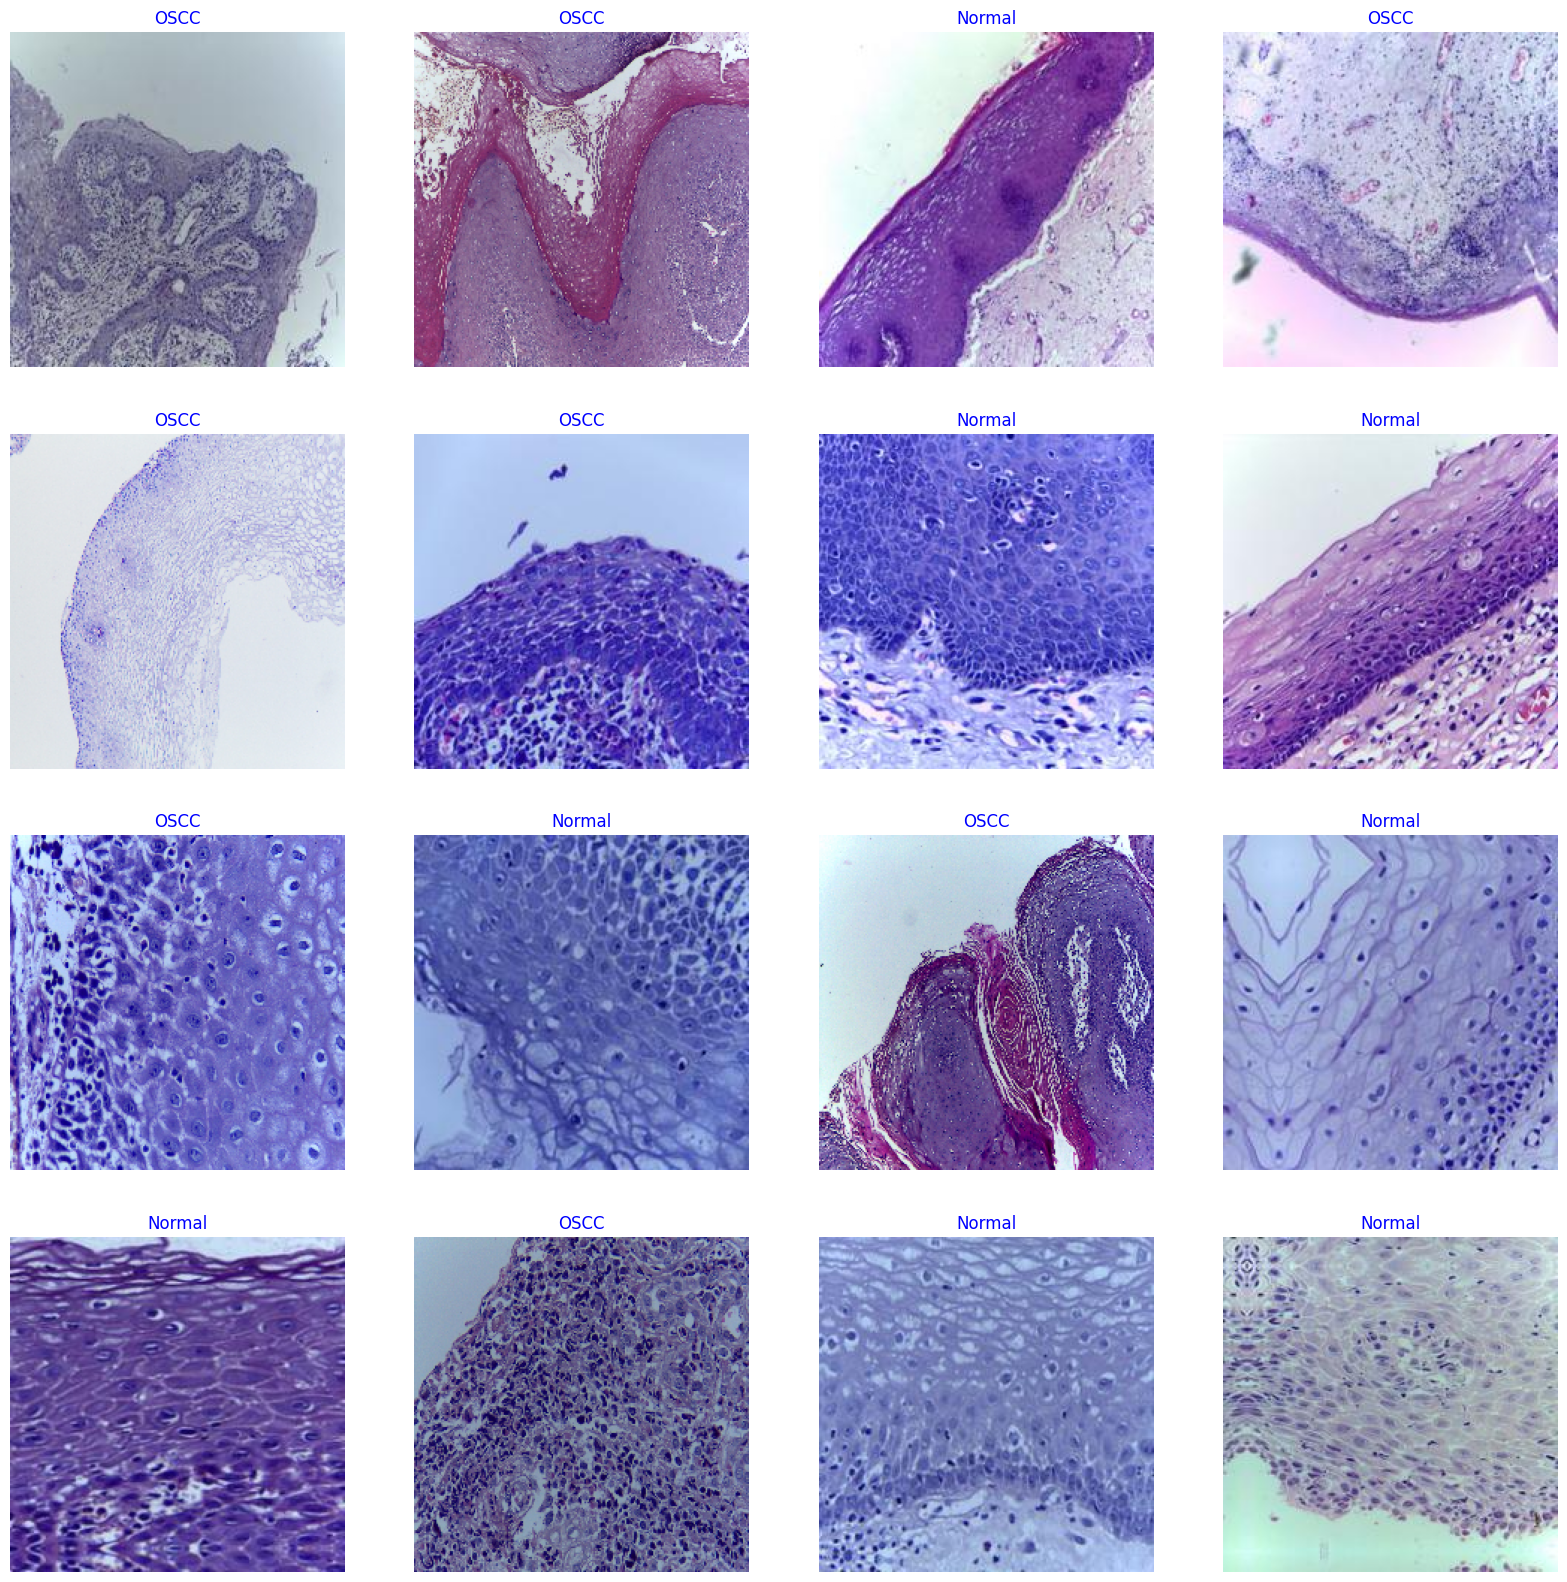

In [ ]:
# Visualizing training dataset
g_dict = train_gen.class_indices  # defines dictionary {'class': index}
classes = list(g_dict.keys())  # defines list of dictionary's keys (classes), classes names: string
images, labels = next(train_gen)  # get a batch size samples from the generator

plt.figure(figsize=(20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255  # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]  # get class of image
    plt.title(class_name, color='blue', fontsize=12)
    plt.axis('off')


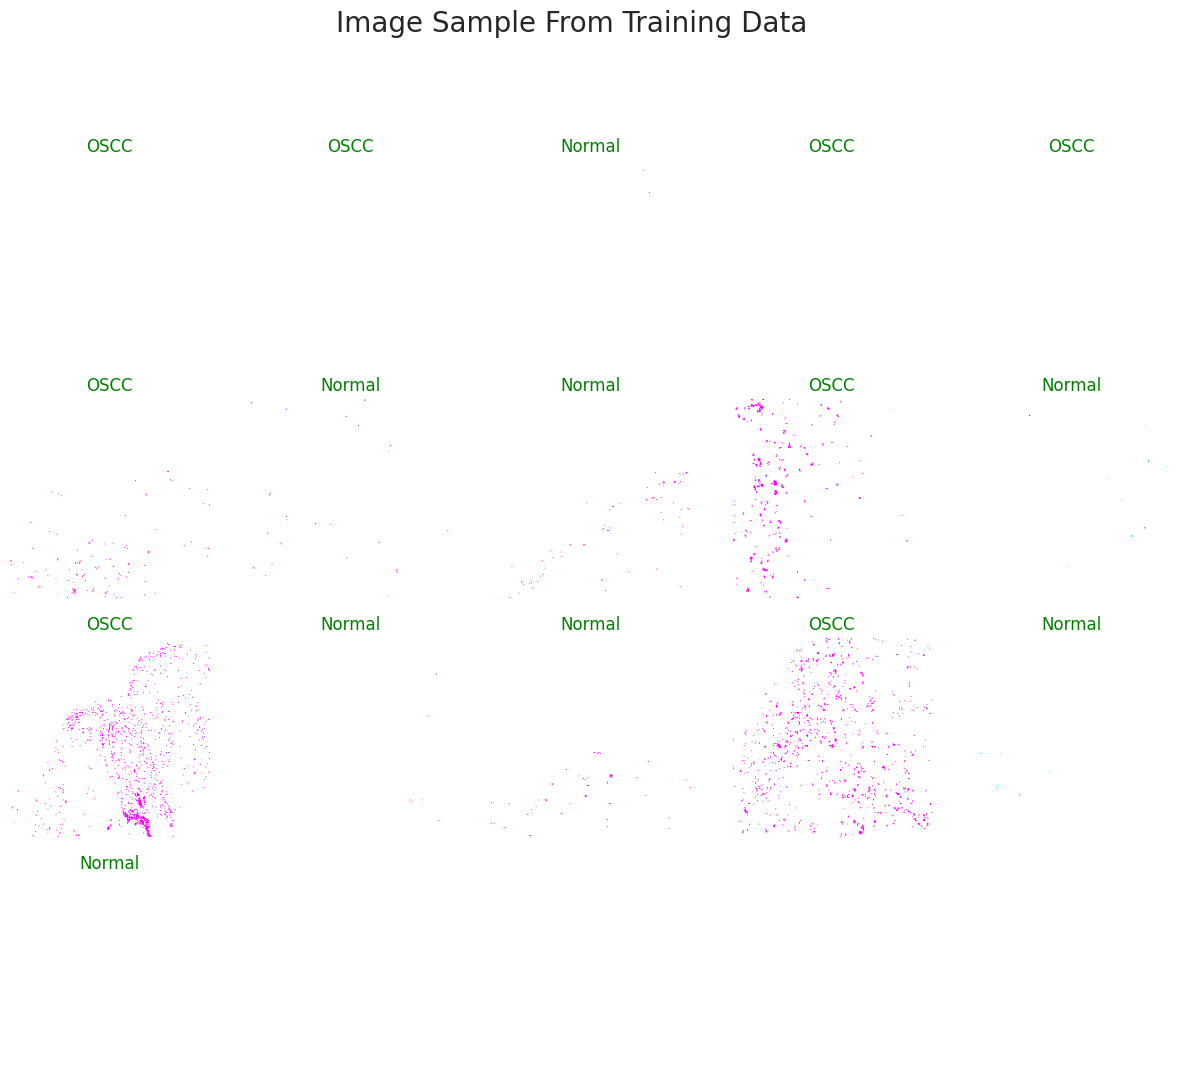

In [ ]:
def show_16_images(img_arr, label_arr, title):
    plt.figure(figsize=(15, 15))
    plt.suptitle(title, fontsize=20)
    for i in range(16):
        plt.subplot(5, 5, i + 1)
        plt.imshow(img_arr[i])
        plt.title(classes[np.argmax(label_arr[i])], color='green', fontsize=12)
        plt.axis('off')
    plt.show()

show_16_images(images, labels, 'Image Sample From Training Data')


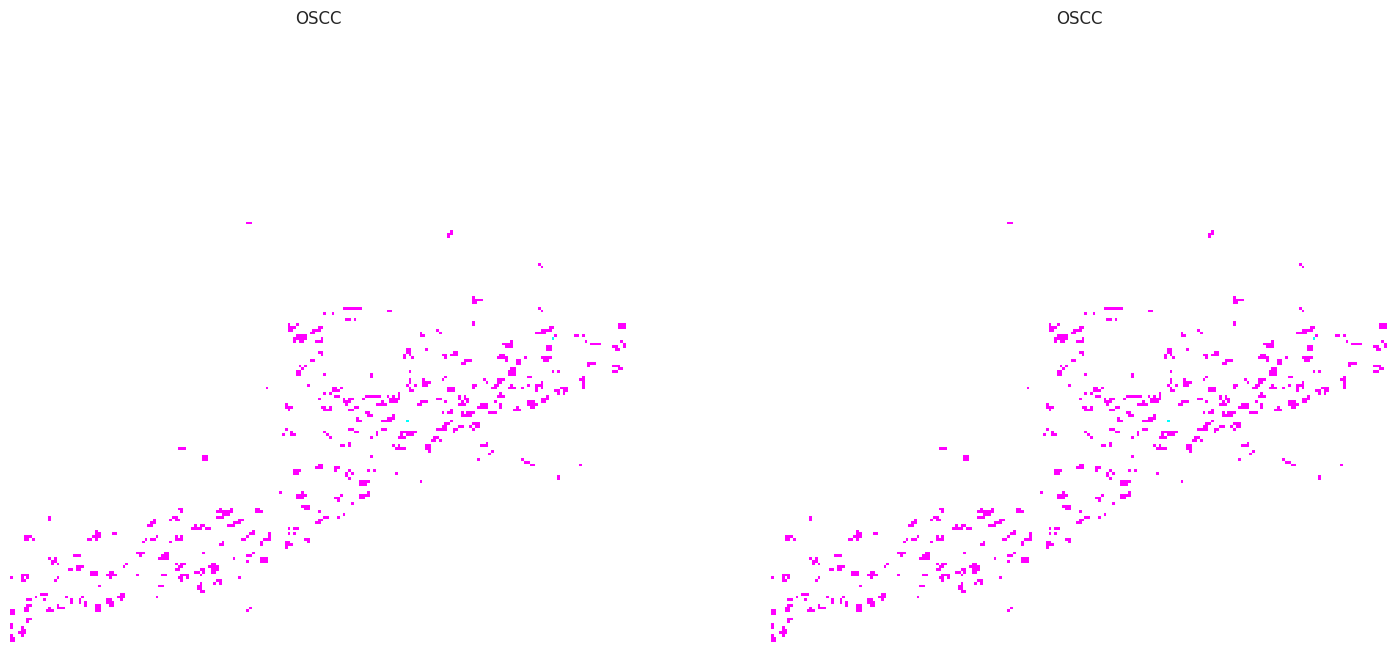

In [ ]:

def plot_data(gen):
    fig, ax = plt.subplots(1, 2, figsize=(18, 8))
    for i in gen:
        image = i[0][0]
        label = i[1][0]
        label_name = classes[np.argmax(label)]
        ax[0].imshow(image, interpolation='nearest')
        ax[0].set_title(label_name)
        ax[0].axis('off')
        if label_name == 'OSCC':
            ax[1].imshow(image, interpolation='nearest')
            ax[1].set_title(label_name)
            ax[1].axis('off')
            break
plot_data(train_gen)


In [ ]:
def plot_augmented_images(df, n_imgs, title, img_size=(224, 224)):
    plt.figure(figsize=(12, 12))
    plt.suptitle(title, fontsize=15)
    # Limit the number of images to the size of the DataFrame
    for i in range(min(n_imgs, len(df))):
        img_path = df['filepaths'][i]
        img = cv2.imread(img_path)
        img = cv2.resize(img, img_size)
        plt.subplot(5, 5, i + 1)
        plt.imshow(img, interpolation='nearest')
        plt.axis('off')
    plt.show()


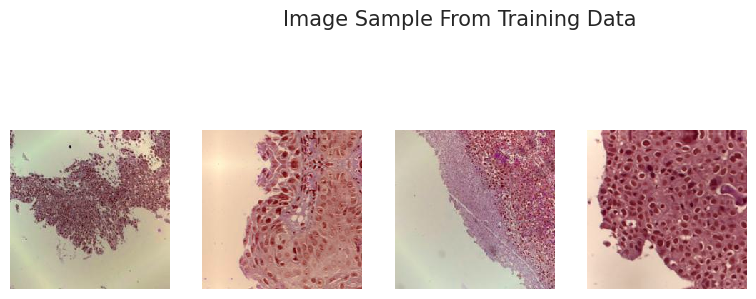

In [ ]:

plot_augmented_images(train_df, 4, 'Image Sample From Training Data')


In [ ]:
def plot_augmented_images_flow(flow, title):
    plt.figure(figsize=(12, 12))
    plt.suptitle(title, fontsize=15)
    for i in range(25):
        plt.subplot(5, 5, i + 1)
        img, label = next(flow)
        plt.imshow(img[0], interpolation='nearest')
        plt.title(classes[np.argmax(label[0])])
        plt.axis('off')
    plt.show()


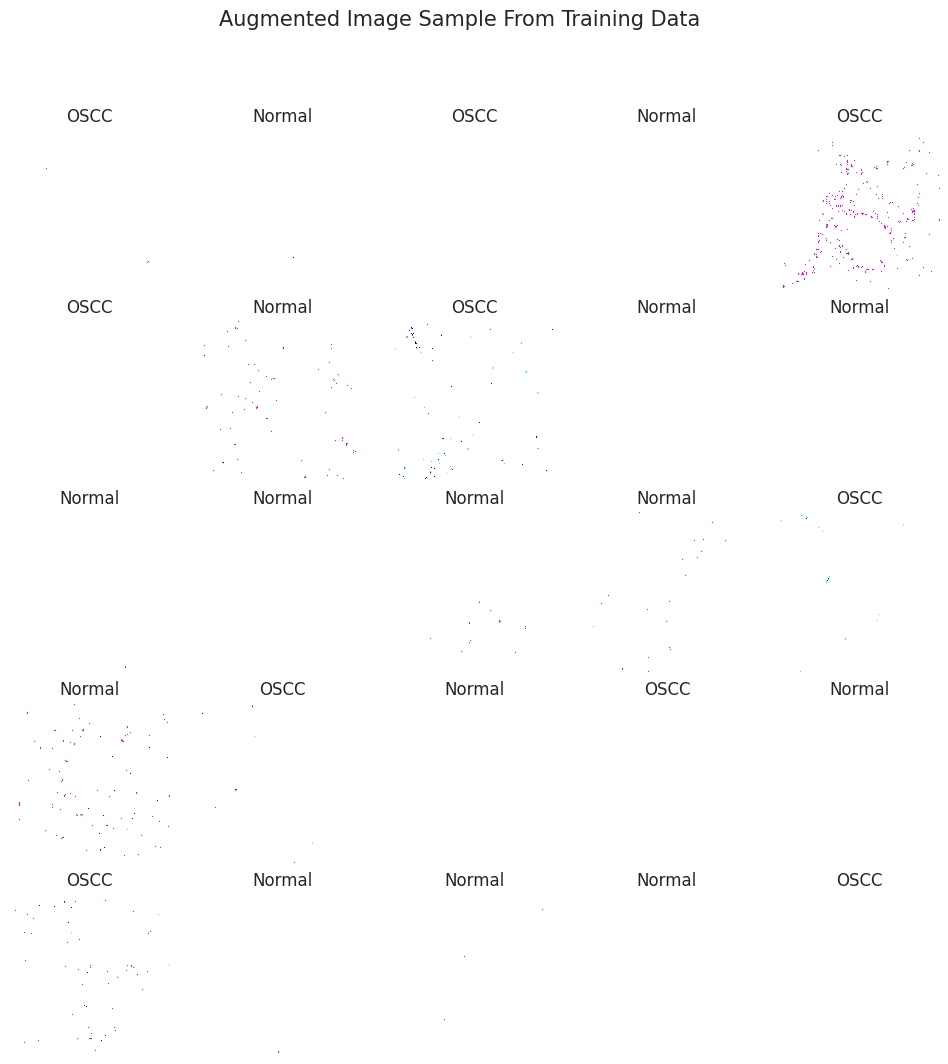

In [ ]:
plot_augmented_images_flow(train_gen, 'Augmented Image Sample From Training Data')


In [ ]:
base_model = tf.keras.applications.EfficientNetB3(include_top=False, weights='imagenet', input_shape=img_shape, pooling='max')


43941136/43941136 [==============================] - 3s 0us/step


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dense, Dropout, LSTM, Reshape, GlobalAveragePooling2D, Flatten
from tensorflow.keras.applications import EfficientNetB3

# Load EfficientNetB3 model
base_model = EfficientNetB3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model
base_model.trainable = False

# Define the model
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Reshape((1, -1)))  # Reshape to (batch_size, timesteps, features) for LSTM
model.add(LSTM(256, return_sequences=True))
model.add(Flatten())
model.add(Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(len(train_gen.class_indices), activation='softmax'))


In [ ]:

# Model summary
model.summary()

from tensorflow.keras.optimizers import Adam
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional  (None, 7, 7, 1536)        10783535  
 )                                                               
                                                                 
 global_average_pooling2d (  (None, 1536)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 reshape (Reshape)           (None, 1, 1536)           0         
                                                                 
 lstm (LSTM)                 (None, 1, 256)            1836032   
                                                                 
 flatten (Flatten)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 1024)              2

In [ ]:
history = model.fit(train_gen,
                    epochs=50,
                    validation_data=valid_gen,
                    callbacks=[early_stopping, checkpoint],
                    verbose=1)


Epoch 1/50
228/228 [==============================] - 1885s 8s/step - loss: 3.2998 - accuracy: 0.7544 - val_loss: 2.1560 - val_accuracy: 0.8363
Epoch 2/50
228/228 [==============================] - 90s 396ms/step - loss: 1.5797 - accuracy: 0.8429 - val_loss: 1.1145 - val_accuracy: 0.8606
Epoch 3/50
228/228 [==============================] - 85s 374ms/step - loss: 0.8661 - accuracy: 0.8775 - val_loss: 0.6594 - val_accuracy: 0.8862
Epoch 4/50
228/228 [==============================] - 86s 375ms/step - loss: 0.5604 - accuracy: 0.8956 - val_loss: 0.4921 - val_accuracy: 0.8849
Epoch 5/50
228/228 [==============================] - 91s 399ms/step - loss: 0.4182 - accuracy: 0.9024 - val_loss: 0.3715 - val_accuracy: 0.9054
Epoch 6/50
228/228 [==============================] - 85s 373ms/step - loss: 0.3318 - accuracy: 0.9158 - val_loss: 0.3541 - val_accuracy: 0.8900
Epoch 7/50
228/228 [==============================] - 85s 372ms/step - loss: 0.2862 - accuracy: 0.9235 - val_loss: 0.2942 - val_acc

In [ ]:
# Evaluate model
loss, accuracy = model.evaluate(test_gen)
print(f"Test accuracy: {accuracy * 100:.2f}%")

17/17 [==============================] - 340s 21s/step - loss: 0.1891 - accuracy: 0.9412
Test accuracy: 94.12%


In [ ]:
`
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'


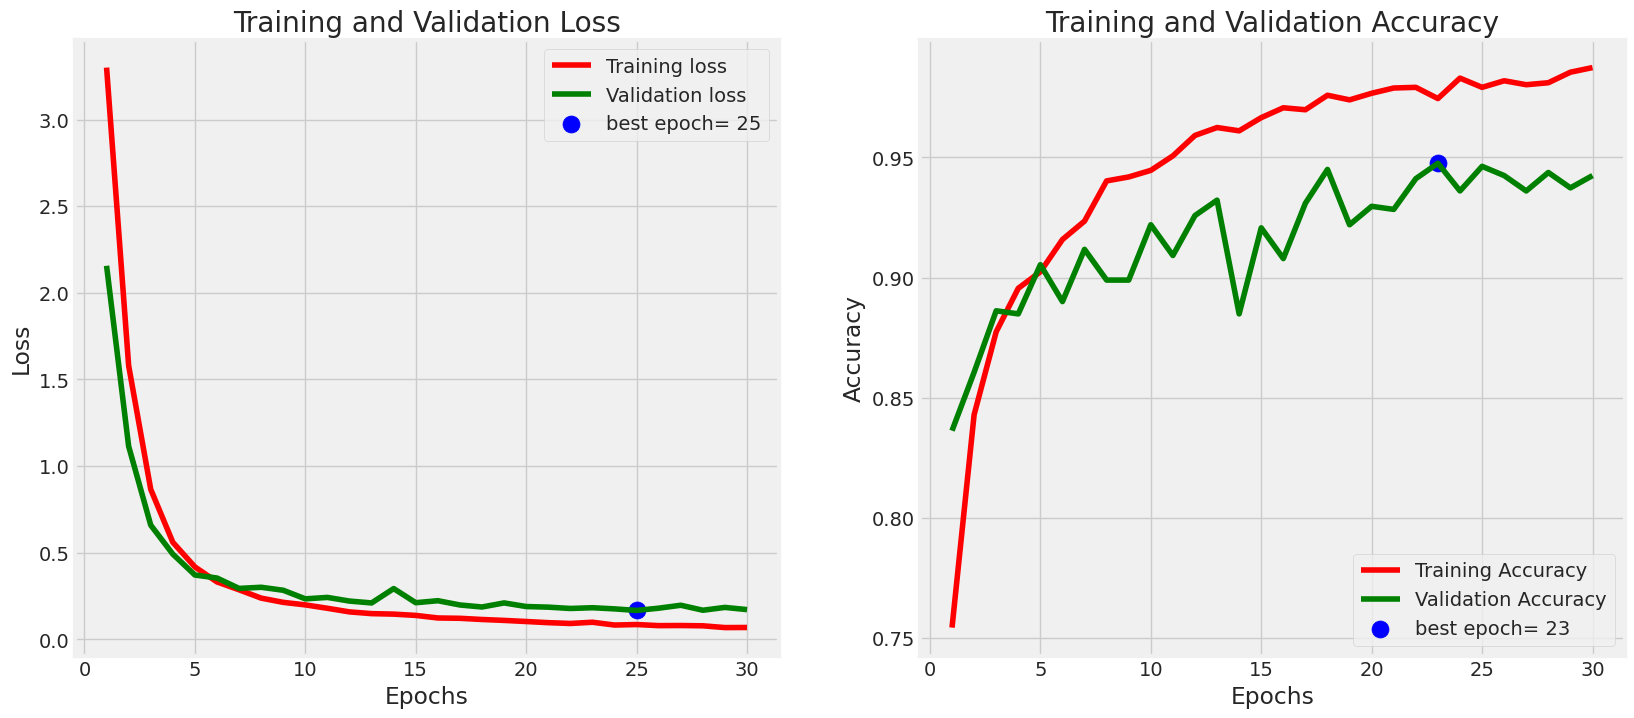

In [ ]:
# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')
plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout
plt.show()


In [ ]:
s_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size
train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)
print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])


17/17 [==============================] - 14s 829ms/step - loss: 0.1891 - accuracy: 0.9412
Train Loss:  0.05237811431288719
Train Accuracy:  0.9926470518112183
--------------------
Validation Loss:  0.1759558618068695
Validation Accuracy:  0.9558823704719543
--------------------
Test Loss:  0.18913935124874115
Test Accuracy:  0.9411764740943909


In [ ]:
preds =model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)


In [ ]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())


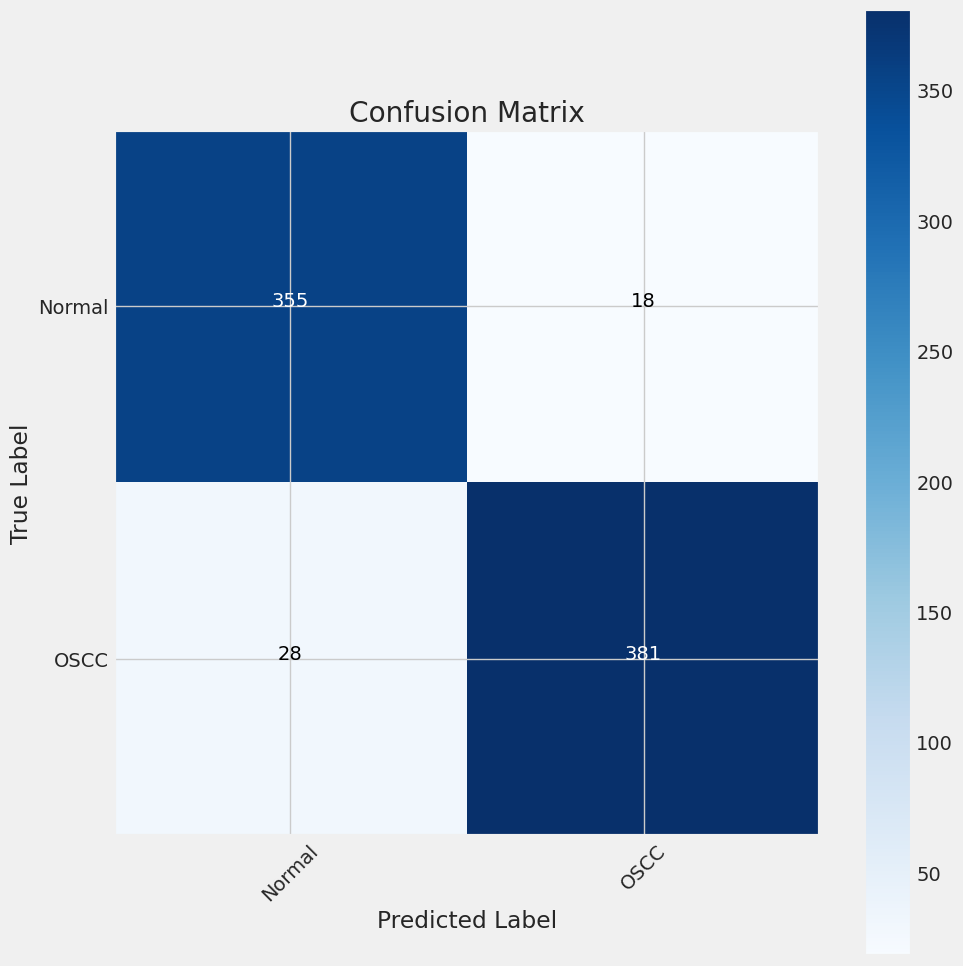

In [ ]:

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)
plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')
plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


In [ ]:
# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

model.save_weights('my_model_weights.h5')

              precision    recall  f1-score   support

      Normal       0.93      0.95      0.94       373
        OSCC       0.95      0.93      0.94       409

    accuracy                           0.94       782
   macro avg       0.94      0.94      0.94       782
weighted avg       0.94      0.94      0.94       782



1/1 [==============================] - 0s 31ms/step


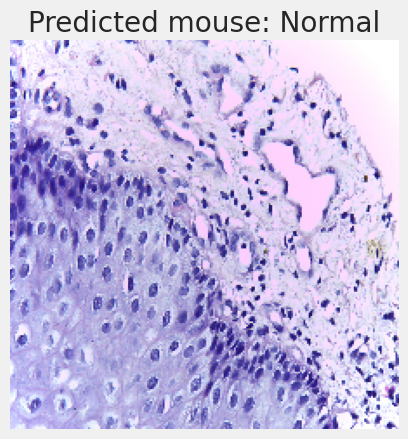

In [ ]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input
from google.colab import files
from google.colab import files
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


def predict_and_display(image_path, model, class_labels):

    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    prediction = model.predict(img_array)
    predicted_class_index = np.argmax(prediction)

    predicted_class_label = class_labels[predicted_class_index]

    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted mouse: {predicted_class_label}")
    plt.show()

# Load your trained model
model.load_weights('/content/my_model_weights.h5')

# Define your class labels (e.g., ['car', 'truck', ...])
class_labels = ['Normal', 'Oral Cancer']


# Replace 'path_to_test_image' with the path to the image you want to test
image_path_to_test = '/content/drive/MyDrive/oral/test/Normal/Normal_400x_88.jpg'
predict_and_display(image_path_to_test, model, class_labels)

